## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import warnings
warnings.filterwarnings('ignore')


import os
from glob import glob
import json

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import sklearn.preprocessing
import sklearn.model_selection

import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

import tensorflow.keras.layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## our modules
import scripts.tools as tools
import scripts.visualization as visualization
from scripts.my_image_generator import MyImageDataGenerator
import scripts.models as models

tf.autograph.set_verbosity(0)

## Handy constants
INPUT_SHAPE = (224, 224, 3)
IMG_SIZE = (224, 224)
TRAINING_BATCH = 32
VALIDATION_BATCH = 64

## Do some early processing of your metadata for easier model training:

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = tools.load_nih_dataset('data/')

# Split the 'Finding Labels' column into binary labels
all_xray_df, disease_labels = tools.split_findings(all_xray_df)

Scans found: 112120 , Total Headers 112120


In [3]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda flag: 'pneumonia' if flag == 1 else 'no finding')

In [4]:
print("NIH X-ray dataset has been loaded :")
all_xray_df.sample(3)

NIH X-ray dataset has been loaded :


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
53629  00013541_000.png     No Finding            0       13541           74   
69954  00017236_036.png   Infiltration           36       17236           46   
24771  00006505_005.png   Infiltration            5        6505           44   

      Patient Gender View Position  OriginalImage[Width  Height]  \
53629              M            PA                 2992     2991   
69954              M            AP                 2500     2048   
24771              M            PA                 2021     2021   

       OriginalImagePixelSpacing[x  ...  Fibrosis  Hernia Infiltration  Mass  \
53629                     0.143000  ...       0.0     0.0          0.0   0.0   
69954                     0.168000  ...       0.0     0.0          1.0   0.0   
24771                     0.194311  ...       0.0     0.0          1.0   0.0   

       No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
53629         1.0     0.0                 0.0        0.0           0.0   
69954         0.0     0.0                 0.0        0.0           0.0   
24771         0.0     0.0                 0.0        0.0           0.0   

       pneumonia_class  
53629       no finding  
69954       no finding  
24771       no finding  

[3 rows x 29 columns]

## Create your training and testing data:

In [5]:
training_df, fda_df = sklearn.model_selection.train_test_split(all_xray_df,
                                                              test_size=0.2,
                                                              stratify=all_xray_df['Pneumonia'])

train_df, valid_df = tools.split_train_validation(training_df,
                                         validation_size=0.4,
                                         train_positive_ratio=0.5,
                                         validation_positive_ratio=0.25)

In [6]:
n_training_samples = len(train_df)
n_training_positive = train_df.Pneumonia.sum()
n_training_negative = n_training_samples - n_training_positive
print(
    f'Training dataframe is composed of {n_training_samples} samples, in which {n_training_positive} are positive and {n_training_negative} are negative.')
print(
    f'This confirms then the {100 * n_training_positive / n_training_samples}/{100 * n_training_negative / n_training_samples}% split between positive and negative labels.')
train_df.head()

Training dataframe is composed of 1374 samples, in which 687.0 are positive and 687.0 are negative.
This confirms then the 50.0/50.0% split between positive and negative labels.


Image Index                                     Finding Labels  \
66771  00016508_012.png                            Consolidation|Pneumonia   
15434  00004034_005.png  Atelectasis|Edema|Effusion|Pneumonia|Pneumothorax   
99634  00026387_001.png                       Edema|Infiltration|Pneumonia   
39186  00010277_000.png  Infiltration|Mass|Nodule|Pleural_Thickening|Ef...   
74541  00018295_003.png                             Infiltration|Pneumonia   

       Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
66771           12       16508           51              F            AP   
15434            5        4034           48              F            AP   
99634            1       26387           71              F            AP   
39186            0       10277           60              M            PA   
74541            3       18295           62              F            AP   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
66771                 2500     2048                        0.168  ...   
15434                 2500     2048                        0.168  ...   
99634                 3056     2544                        0.139  ...   
39186                 2438     2989                        0.143  ...   
74541                 2500     2048                        0.168  ...   

       Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
66771       0.0     0.0          0.0   0.0         0.0     0.0   
15434       0.0     0.0          0.0   0.0         0.0     0.0   
99634       0.0     0.0          1.0   0.0         0.0     0.0   
39186       0.0     0.0          1.0   1.0         0.0     1.0   
74541       0.0     0.0          1.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
66771                 0.0        1.0           0.0        pneumonia  
15434                 0.0        1.0           1.0        pneumonia  
99634                 0.0        1.0           0.0        pneumonia  
39186                 1.0        1.0           0.0        pneumonia  
74541                 0.0        1.0           0.0        pneumonia  

[5 rows x 29 columns]

In [7]:
n_validation_samples = len(valid_df)
n_validation_positive = valid_df.Pneumonia.sum()
n_validation_negative = n_validation_samples - n_validation_positive
print(
    f'Validation dataframe is composed of {n_validation_samples} samples, in which {n_validation_positive} are positive and {n_validation_negative} are negative.')
print(
    f'This confirms then the {100 * n_validation_positive / n_validation_samples}/{100 * n_validation_negative / n_validation_samples}% split between positive and negative labels.')
valid_df.head()

Validation dataframe is composed of 1832 samples, in which 458.0 are positive and 1374.0 are negative.
This confirms then the 25.0/75.0% split between positive and negative labels.


Image Index                             Finding Labels  \
50403  00012761_007.png                                  Pneumonia   
67888  00016778_016.png                     Infiltration|Pneumonia   
77005  00018921_021.png  Edema|Infiltration|Pneumonia|Pneumothorax   
82640  00020322_007.png                     Infiltration|Pneumonia   
55056  00013779_000.png                                  Pneumonia   

       Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
50403            7       12761           54              M            PA   
67888           16       16778           26              M            AP   
77005           21       18921           43              F            AP   
82640            7       20322           44              M            PA   
55056            0       13779           66              M            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
50403                 2992     2991                        0.143  ...   
67888                 3056     2544                        0.139  ...   
77005                 2500     2048                        0.168  ...   
82640                 2992     2991                        0.143  ...   
55056                 2992     2991                        0.143  ...   

       Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
50403       0.0     0.0          0.0   0.0         0.0     0.0   
67888       0.0     0.0          1.0   0.0         0.0     0.0   
77005       0.0     0.0          1.0   0.0         0.0     0.0   
82640       0.0     0.0          1.0   0.0         0.0     0.0   
55056       0.0     0.0          0.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
50403                 0.0        1.0           0.0        pneumonia  
67888                 0.0        1.0           0.0        pneumonia  
77005                 0.0        1.0           1.0        pneumonia  
82640                 0.0        1.0           0.0        pneumonia  
55056                 0.0        1.0           0.0        pneumonia  

[5 rows x 29 columns]

In [8]:
n_fda_samples = len(fda_df)
n_fda_positive = fda_df.Pneumonia.sum()
n_fda_negative = n_fda_samples - n_fda_positive
print(
    f'FDA dataframe is composed of {n_fda_samples} samples, in which {n_fda_positive} are positive and {n_fda_negative} are negative.')
fda_df.head()

FDA dataframe is composed of 22424 samples, in which 286.0 are positive and 22138.0 are negative.


Image Index                     Finding Labels  Follow-up #  \
90048   00022380_005.png                         No Finding            5   
68953   00017010_000.png                      Effusion|Mass            0   
111702  00030606_004.png                         No Finding            4   
17991   00004832_010.png  Atelectasis|Effusion|Infiltration           10   
78101   00019176_011.png                        Atelectasis           11   

        Patient ID  Patient Age Patient Gender View Position  \
90048        22380           56              M            AP   
68953        17010           57              M            AP   
111702       30606           59              M            PA   
17991         4832           37              M            AP   
78101        19176           67              F            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
90048                  3056     2544                     0.139000  ...   
68953                  2500     2048                     0.168000  ...   
111702                 2021     2021                     0.194311  ...   
17991                  3056     2544                     0.139000  ...   
78101                  2778     2991                     0.143000  ...   

        Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
90048        0.0     0.0          0.0   0.0         1.0     0.0   
68953        0.0     0.0          0.0   1.0         0.0     0.0   
111702       0.0     0.0          0.0   0.0         1.0     0.0   
17991        0.0     0.0          1.0   0.0         0.0     0.0   
78101        0.0     0.0          0.0   0.0         0.0     0.0   

        Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
90048                  0.0        0.0           0.0       no finding  
68953                  0.0        0.0           0.0       no finding  
111702                 0.0        0.0           0.0       no finding  
17991                  0.0        0.0           0.0       no finding  
78101                  0.0        0.0           0.0       no finding  

[5 rows x 29 columns]

In [9]:
n_samples = len(all_xray_df)
n_positive = all_xray_df.Pneumonia.sum()
print(
    f'With respect to the complete dataset, training set accounts for {100 * n_training_positive / n_positive:0.2f}% of the pneumonia cases, validation set to {100 * n_validation_positive / n_positive:0.2f}% and FDA set to {100 * n_fda_positive / n_positive:0.2f}%')

With respect to the complete dataset, training set accounts for 48.01% of the pneumonia cases, validation set to 32.01% and FDA set to 19.99%


In [10]:
print('Wight of each class will be adjusted in the training phase by factors:')
class_weight = {1: float(n_training_negative) / (n_training_positive + n_training_negative),
                0: float(n_training_positive) / (n_training_positive + n_training_negative)}
print(class_weight)

steps_per_epoch = np.ceil(n_training_samples / TRAINING_BATCH)
validation_steps = np.ceil(n_validation_samples / VALIDATION_BATCH)
print(f'Training will be performed with {steps_per_epoch} steps_per_epoch and {validation_steps} validation_steps')

Wight of each class will be adjusted in the training phase by factors:
{1: 0.5, 0: 0.5}
Training will be performed with 43.0 steps_per_epoch and 29.0 validation_steps


# Now we can begin our model-building & training

#### Image augmentation

In [11]:
def make_train_gen(df):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    train_idg = MyImageDataGenerator(
        # rescale=1 / 255,
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.1,
        width_shift_range=0.1,
        rotation_range=10,
        shear_range=0.1,
        zoom_range=0.1)

    gen = train_idg.flow_from_dataframe(dataframe=df,
                                              directory=None,
                                              x_col='path',
                                              y_col='pneumonia_class',
                                              class_mode='binary',
                                              target_size=IMG_SIZE,
                                              batch_size=TRAINING_BATCH,
                                              shuffle=True)

    return gen


def make_test_gen(df):
    # Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    val_idg = MyImageDataGenerator(
        # rescale=1 / 255
    )

    gen = val_idg.flow_from_dataframe(dataframe=df,
                                          directory=None,
                                          x_col='path',
                                          y_col='pneumonia_class',
                                          class_mode='binary',
                                          target_size=IMG_SIZE,
                                          batch_size=VALIDATION_BATCH,
                                          shuffle=True)

    return gen

In [12]:
train_gen = make_train_gen(train_df)
val_gen = make_test_gen(valid_df)
fda_gen = make_test_gen(fda_df)

Found 1374 validated image filenames belonging to 2 classes.
Found 1832 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


#### Training-set images

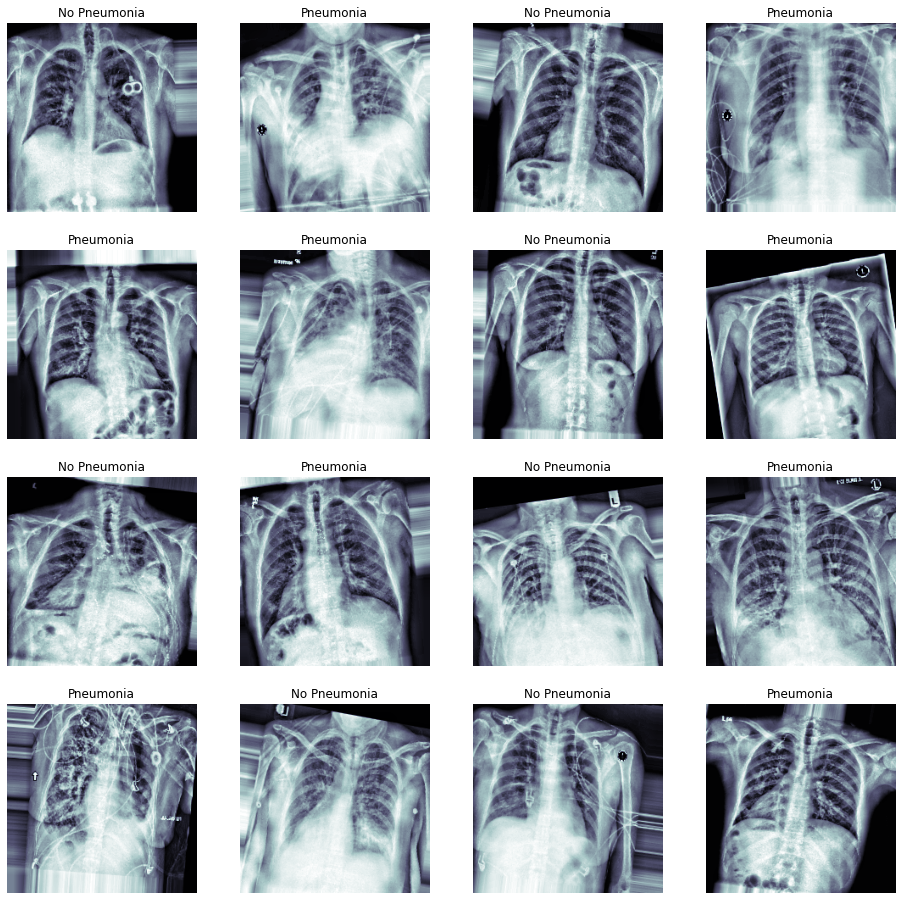

In [13]:
## May want to look at some examples of our augmented training data.
## This is helpful for understanding the extent to which data is being manipulated prior to training,
## and can be compared with how the raw data look prior to augmentation

trainX, trainY = next(train_gen)
visualization.batch_image_peak(trainX, trainY)

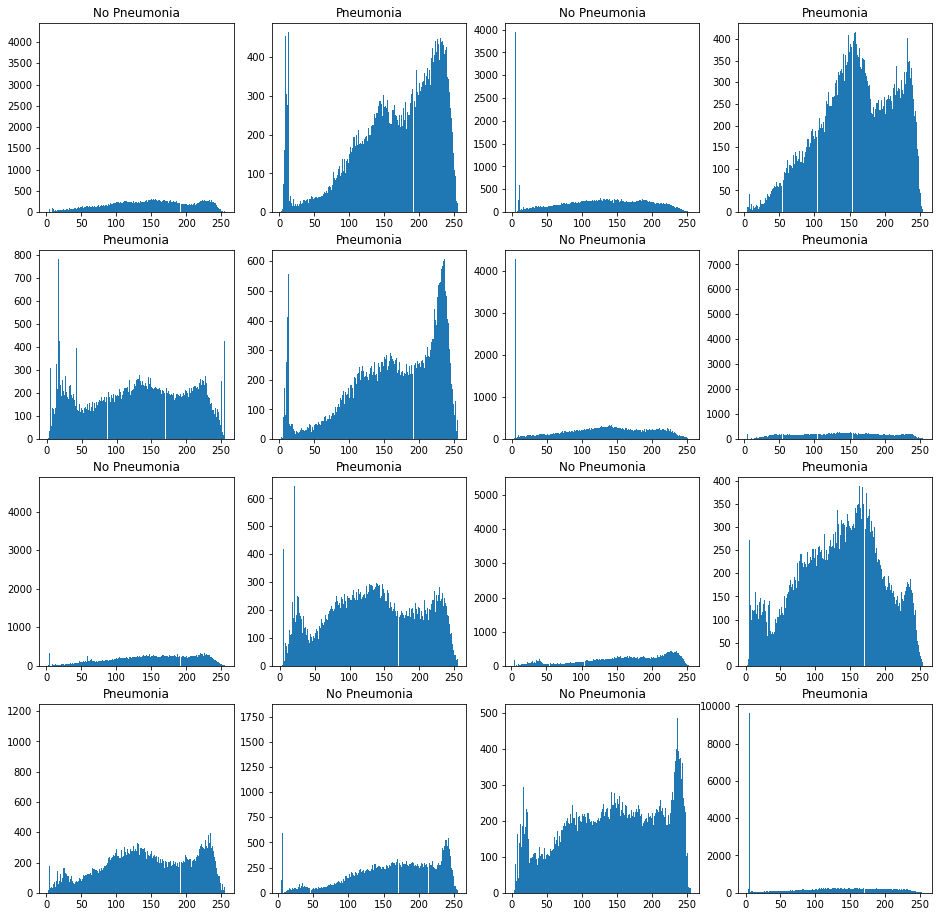

In [14]:
visualization.batch_histogram_peak(trainX, trainY)

#### Validation-set images


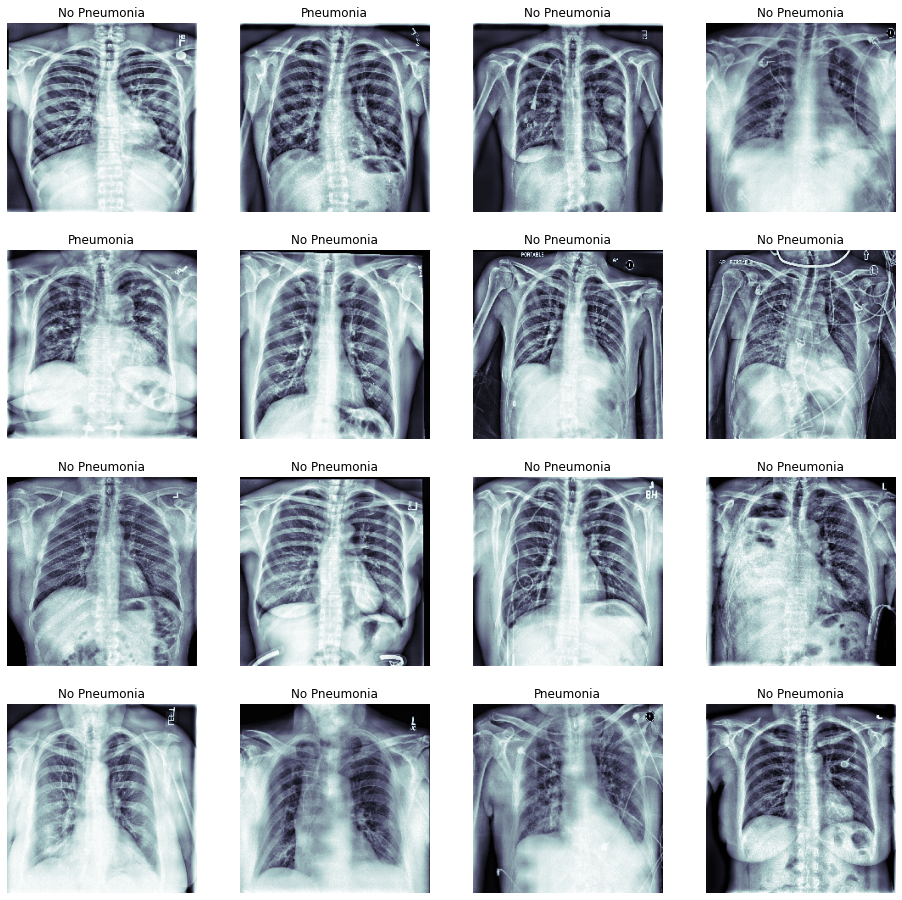

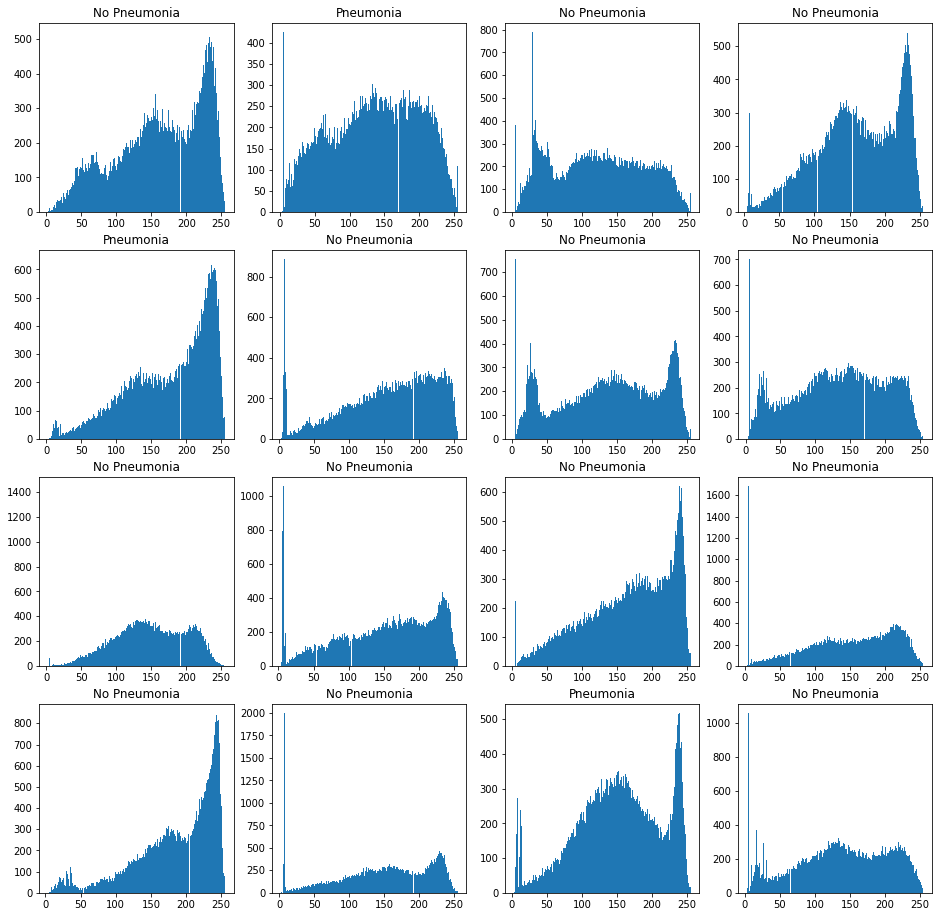

In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
visualization.batch_image_peak(valX, valY)
visualization.batch_histogram_peak(valX, valY)

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning


In [16]:
DropoutFactor = 0.5
WeightDecay = 1e-6

inputs = tf.keras.Input(shape=INPUT_SHAPE)

pre_trained = models.VGG16(INPUT_SHAPE)
# pre_trained = models.ResNet50(INPUT_SHAPE)
preprocessing = pre_trained.get_preprocessing()
# load pre-trained model
base_model = pre_trained.get_base_model()
base_model.trainable = False

x = preprocessing(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten(name='Flatten')(x)
x = tf.keras.layers.Dropout(DropoutFactor)(x)
outputs = tf.keras.layers.Dense(1, name='prediction', activation='sigmoid')(x)
my_model = tf.keras.Model(inputs, outputs)

print(my_model.summary())
for layer in my_model.layers:
    print(f'{layer.name}: {layer.trainable}')

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
VGG16_preprocessing (Sequent (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
Flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
____________________________________________

In [17]:
PATIENCE = 15

METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_loss'
EVALUATION_MODE = 'auto'

weight_path = "{}.best.hdf5".format('warmup')

checkpoint = ModelCheckpoint(weight_path,
                             monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                             verbose=1,
                             save_best_only=True,
                             mode=EVALUATION_MODE,
                             save_weights_only=False)

early = EarlyStopping(monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                      mode=EVALUATION_MODE,
                      patience=PATIENCE)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='log/', histogram_freq=1)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                                                 factor=0.5,
                                                 patience=5,
                                                 verbose=1,
                                                 mode='auto')

callbacks_list = [checkpoint, early, tensorboard_callback, reduce_LR]

In [18]:
# Compile the model!
optimizer = Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy()]

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Start training!

In [19]:
## train your model
MAX_EPOCHS = 50

history = my_model.fit(train_gen,
                       validation_data=val_gen,
                       epochs=MAX_EPOCHS,
                       class_weight=class_weight,
                       steps_per_epoch=steps_per_epoch,
                       validation_steps=validation_steps,
                       callbacks=callbacks_list
                       )

2021-11-04 18:00:26.131673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-04 18:00:28.589942: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-04 18:00:29.346433: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-04 18:00:29.577577: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2021-11-04 18:00:30.857655: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is 

 1/43 [..............................] - ETA: 9:26 - loss: 3.5336 - binary_accuracy: 0.5625

2021-11-04 18:00:39.702735: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-04 18:00:39.702759: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/43 [>.............................] - ETA: 21s - loss: 3.2947 - binary_accuracy: 0.5625 

2021-11-04 18:00:40.188928: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-04 18:00:40.189273: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-04 18:00:40.216150: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 152 callback api events and 149 activity events. 
2021-11-04 18:00:40.219002: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-04 18:00:40.222005: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/profile/2021_11_04_18_00_40

2021-11-04 18:00:40.223935: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/train/plugins/profile/2021_11_04_18_00_40/perrusi-PC.trace.json.gz
2021-11-04 18:00:40.229513: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/p

40/43 [==========================>...] - ETA: 1s - loss: 3.0555 - binary_accuracy: 0.5195 

2021-11-04 18:00:59.657785: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-04 18:00:59.657857: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-04 18:00:59.751974: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


43/43 [==============================] - ETA: 0s - loss: 3.0488 - binary_accuracy: 0.5211

2021-11-04 18:01:09.853953: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2021-11-04 18:01:10.262706: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


43/43 [==============================] - 94s 2s/step - loss: 3.0488 - binary_accuracy: 0.5211 - val_loss: 4.4437 - val_binary_accuracy: 0.4410

Epoch 00001: val_loss improved from inf to 4.44373, saving model to warmup.best.hdf5
Epoch 2/50
43/43 [==============================] - 43s 1s/step - loss: 2.8637 - binary_accuracy: 0.5051 - val_loss: 4.1489 - val_binary_accuracy: 0.4602

### Fine-tunning

In [19]:
my_model.load_weights(weight_path)  # load early stopped weights

In [20]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_top_layers = pre_trained.get_fine_tuning_top_layer()

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-fine_tune_top_layers]:
    layer.trainable = False
for layer in base_model.layers[-fine_tune_top_layers:]:
    layer.trainable = True

my_model.summary()
print(len(my_model.trainable_variables))

Number of layers in the base model:  19
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
VGG16_preprocessing (Sequent (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
Flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 13,004,289
Non-trainable params: 1,735,488
_

In [23]:
# reset generators
train_gen.reset()
val_gen.reset()

# re-compile the model with a smaller learning rate
optimizer = Adam(learning_rate=1e-6)
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

weight_path = "{}.best.hdf5".format('fine_tunning')
checkpoint = ModelCheckpoint(weight_path,
                             monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                             verbose=1,
                             save_best_only=True,
                             mode=EVALUATION_MODE,
                             save_weights_only=False)

callbacks_list = [checkpoint, early, tensorboard_callback, reduce_LR]

In [ ]:
## re-train your model
MAX_FINE_TUNED_EPOCHS = history.epoch[-1] + 50

history_fine = my_model.fit(train_gen,
                            validation_data=val_gen,
                            initial_epoch=history.epoch[-1],
                            epochs=MAX_FINE_TUNED_EPOCHS,
                            callbacks=callbacks_list,
                            class_weight=class_weight,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            )

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)

In [25]:
# Use model for inference on each dataset
train_gen.reset()
val_gen.reset()
fda_gen.reset()

train_predY = my_model.predict(train_gen, batch_size=TRAINING_BATCH, verbose=True)
val_predY = my_model.predict(val_gen, batch_size=VALIDATION_BATCH, verbose=True)
fda_predY = my_model.predict(fda_gen, batch_size=VALIDATION_BATCH, verbose=True)


351/351 [==============================] - 265s 756ms/step


In [26]:
# Evaluate model for each dataset
train_gen.reset()
val_gen.reset()
fda_gen.reset()

train_eval = my_model.evaluate(train_gen, batch_size=TRAINING_BATCH, verbose=True)
val_eval = my_model.evaluate(val_gen, batch_size=VALIDATION_BATCH, verbose=True)
fda_eval = my_model.evaluate(fda_gen, batch_size=VALIDATION_BATCH, verbose=True)


351/351 [==============================] - 225s 640ms/step - loss: 0.7126 - binary_accuracy: 0.5561


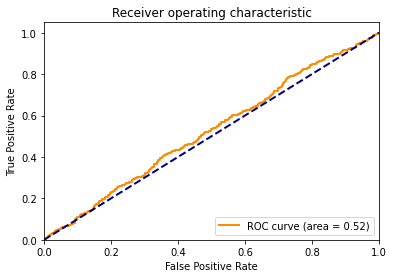

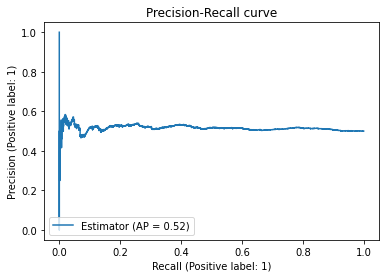

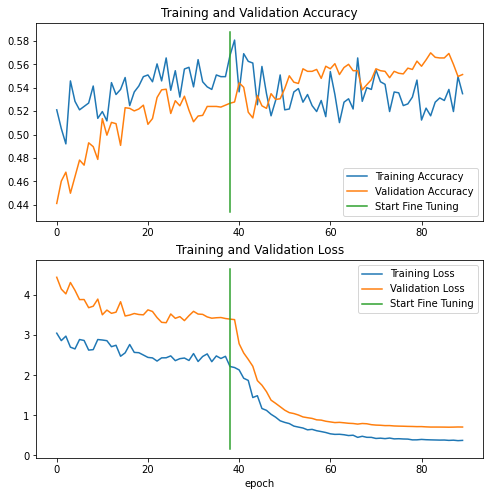

<Figure size 432x288 with 0 Axes>

In [30]:
## plot performance metrics
visualization.plot_auc(train_gen.labels, train_predY)
visualization.precision_recall(train_gen.labels, train_predY)
visualization.plot_history_fine(history, history_fine)
plt.savefig('history.png')


Now let's choose a threshold with desired precision/recall balance based on the training data

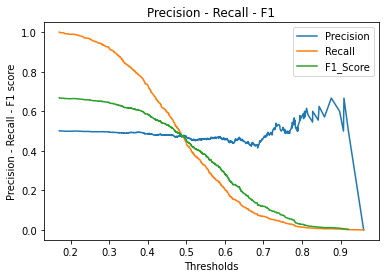

In [27]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(train_gen.labels, train_predY)
f1_scores = tools.compute_f1(precision, recall)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1_Score')
plt.xlabel('Thresholds')
plt.ylabel('Precision - Recall - F1 score')
plt.title("Precision - Recall - F1")
plt.legend(['Precision', 'Recall', 'F1_Score'], loc='upper right')
plt.show()

In [28]:
# remove NAN
f1_scores = f1_scores[~np.isnan(f1_scores)]


Chosen F1 score 0.48759744861800147, precision 0.47579529737206083, recall 0.5007278020378457 for threshold 0.5


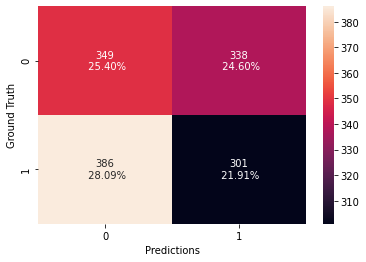

In [34]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    return index

# idx = np.argmax(f1_scores)
idx = find_nearest_idx(recall, 0.5)
# idx = np.argmax(precision[:-1])

threshold = 0.5
print(f'Chosen F1 score {f1_scores[idx]}, precision {precision[idx+1]}, recall {recall[idx+1]} for threshold {threshold}')

visualization.confusion_matrix(train_gen.labels, train_predY > threshold)
plt.show()

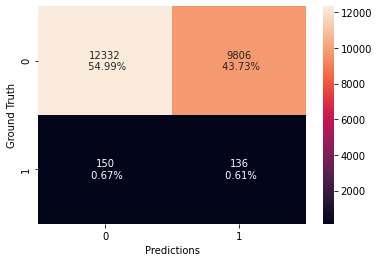

In [35]:
# Apply it to the FDA set
visualization.confusion_matrix(fda_gen.labels, fda_predY > threshold)
plt.show()


1/1 [==============================] - 0s 49ms/step


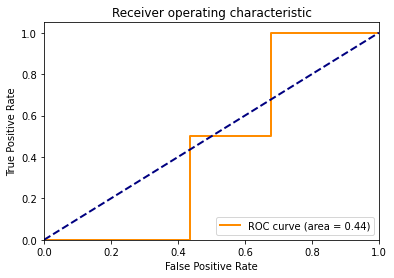

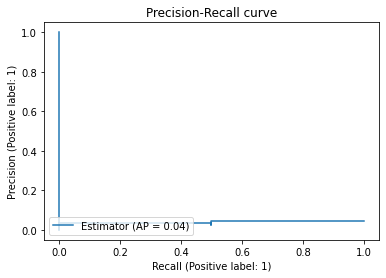

In [52]:
fda_gen.reset()
valX, valY = fda_gen.next()
batchY = my_model.predict(valX, batch_size=VALIDATION_BATCH, verbose=True)
visualization.plot_auc(valY, batchY)
visualization.precision_recall(valY, batchY)



Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

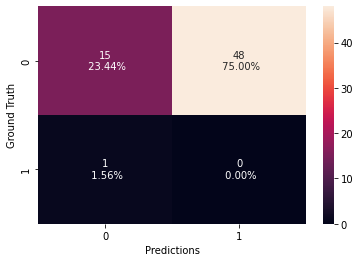

In [47]:
visualization.confusion_matrix(valY, batchY > threshold)
plt.show()

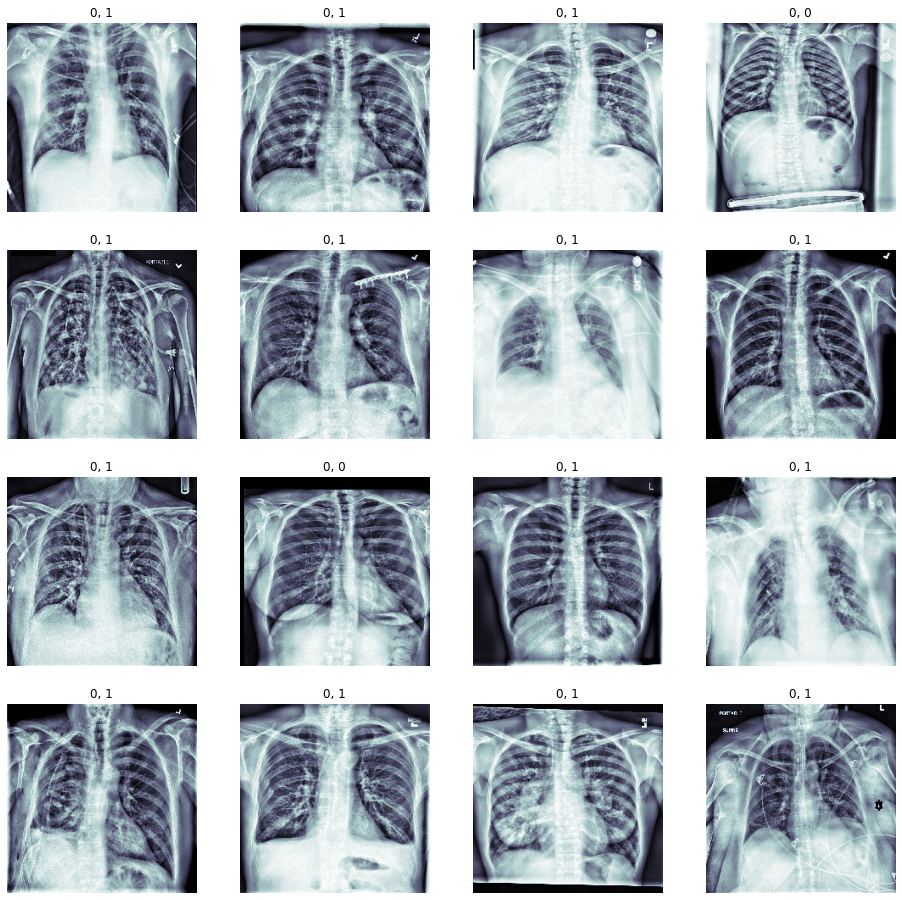

In [48]:
## Let's look at some examples of true vs. predicted with our best model:

fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:, :, 0], cmap='bone')
    if c_y == 1:
        if batchY[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if batchY[i] > threshold:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i = i + 1

In [49]:
## Just save model architecture to a .json:

my_model.save("my_model.h5")

In [ ]:
import json

# Save it under the form of a json file
# json.dump(history.history, open('history.json', 'w'))
# json.dump(history_fine.history, open('history_fine.json', 'w'))

### References
* https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

